# Optimal Hedged Monte Carlo and Variance Reduction

Author: Jerry Xia

Date: 2018/06/19

## 1 Introduction

This is a Python Notebook about variance reduction Monte Carlo simulations. In this script, I implemented the following variance reduction methods as well as their antithetic variates' version:

* regular Monte Carlo
* Monte Carlo with delta-based control variates
* optimal hedged Monte Carlo

Due to the significance and robustness, I mainly focus on the optimal hedged Monte Carlo (OHMC) in option pricing. We invoke this method to price European options and make comparison with other methods.

### 1.1 Facts
* The option price is not simply the average value of the discounted future pay-off over the objective (or historical) probability distribution
* The requirement of absence of arbitrage opportunities is equivalent to the existence of "risk-neutral measure", such that the price is indeed its average discounted future pay-off.
* Risk in option trading cannot be eliminated

### 1.2 Objective
* It would be satisfactory to have an option theory where the objective stochastic process of the underlying is used to calculate the option price, the hedge strategy and the *residual risk*.

### 1.3 Advantages
* It is a versatile methods to price complicated path-dependent options.
* Considerable variance reduction scheme for Monte Carlo
* It provide not only a numerical estimate of the option price, but also of the optimal hedge strategy and of the residual risk.
* This method does not rely on the notion of risk-neutral measure, and can be used to any model of the true dynamics of the underlying

## 2 Underlying dynamics

### Black-Scholes Model
$$dS = r S dt + \sigma S dW_t$$
$$log S_{t+1} = log S_t +(r - \frac{\sigma^2}{2})\Delta t + \sigma \sqrt{\Delta t} \epsilon$$
where
    $$\epsilon \sim N(0,1)$$


## 3 Methodology

### 3.1 Notation
Option price always requires to work backward. That is because the option price is known exactly at the maturity. As with other schemes, we determine the option price step by step from the maturity $t=K\tau=T$ to the present time $t=0$. The unit of time being $\tau$, for example, one day. We simulate $N$ trajectories. In trajectory i, the price of the underlying asset at time $k\tau$ is denoted as $S_k^{(i)}$. The price of the derivative at time $k\tau$ is denoted as $C_k$, and the hedge function is $H_k$. We define an optimal hedged portfolio as
$$W_k^{(i)} = C_k(S_k^{(i)}) + H_k(S_k^{(i)})S_k^{(i)}$$
The one-step change of our portfolio is
$$\Delta W_k^{(i)}= df(k,k+1) C_{k+1}(S_{k+1}^{(i)}) - C_k(S_k^{(i)}) + H_k(S_{k}^{(i)}) (df2(k,k+1) S_{k+1}^{(i)} - S_{k}^{(i)})$$
Where $df(k,k+1)$ is the discounted factor from time $k\tau$ to $(k+1) \tau$, $df2(k,k+1)$ is the discounted factor considering dividend $e^{-(r-q)(t_{k+1}-t_k)}$

### 3.2 Objective
The optimal hedged algorithm can be interpreted as the following optimal problem

\begin{align}
\mbox{minimize}\quad & \quad Var[\Delta W_k]\\
\mbox{subject to}\quad & \quad E[\Delta W_k]=0
\end{align}

It means we should try to minimize the realized volatility of hedged portfolio while maintaining the expected value of portfolio unchanged.

### 3.3 Basis Functions
The original optimization is very difficult to solve. Thus we assume a set of basis function and solved it in such subspace. We use $N_C$and $N_H$ to denote the number of basis functions for price and hedge.

\begin{align}
C_k(\cdot) &= \sum_{i=0}^{N_C} a_{k,i} A_i(\cdot)\\
H_k(\cdot) &= \sum_{i=0}^{N_H} b_{k,i} B_i(\cdot)
\end{align}

The basis functions $A_i$ and $B_i$ are priori determined and need not to be identical. The coefficients $a_i$ and $b_i$ can be calibrated by solving the optimal problem.

### 3.4 Numerical Solution

\begin{align}
\mbox{minimize}\quad & \quad \frac{1}{N} \sum_{i=1}^N \Delta W_k^{(i)2}\\
\mbox{subject to}\quad & \quad \frac{1}{N} \sum_{i=1}^N \Delta W_k^{(i)}=0
\end{align}

Denote the discounted forward underlying price change at time $k\tau$ as

$$\Delta S_k = df2(k,k+1) S_{k+1} - S_k$$

Define

\begin{align}
Q_k &= \begin{bmatrix}
    -A_{k,1}(S_k^{(1)}) & \cdots & -A_{k,N_C}(S_k^{(1)}) & B_{k,1}(S_k^{(1)})\Delta S_k^{(1)}& \cdots  & B_{k,N_H}(S_k^{(1)})\Delta S_k^{(1)} \\
    -A_{k,1}(S_k^{(2)}) & \cdots & -A_{k,N_C}(S_k^{(2)}) & B_{k,1}(S_k^{(2)})\Delta S_k^{(2)}& \cdots  & B_{k,N_H}(S_k^{(1)})\Delta S_k^{(2)} \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
    -A_{k,1}(S_k^{(N)}) & \cdots & -A_{k,N_C}(S_k^{(N)}) & B_{k,1}(S_k^{(N)})\Delta S_k^{(N)}& \cdots  & B_{k,N_H}(S_k^{(N)})\Delta S_k^{(N)}
    \end{bmatrix}\\\\
c_k &= (a_{k,1}, \cdots a_{k,N_C}, b_{k,1}, \cdots, b_{k,N_H})^T\\\\
v_{k} &= df(k,k+1) C_{k+1}(S_{k+1}^{})
\end{align}

As for $v_k$, note that we know the exact value at maturity, which means there is no need to approximate price in terms of basis functions, that is

\begin{align}
v_k = \begin{cases}
df(N-1,N)\ payoff(S_N),\quad & k=N-1\\
df(k,k+1)\ \sum_{i=1}^{N_C} a_{k+1,i} A_i(S_{k+1}), \quad & 0<k<N-1\\
df(0,1)\ C_1(S_1), \quad & k=0
\end{cases}
\end{align}

Then, the optimization problem can be expressed as

\begin{align}
\arg\min_{c_k}\quad & \quad (v_{k} + Q_k c_k)^T (v_{k} + Q_k c_k)\\
\mbox{subject to}\quad & \quad 1_{[N\times1]}^T (v_{k}  + Q_k c_k)=0
\end{align}

In step k, since we already know the information ($v_{k}$) in step k+1. By canceling the constant term, the optimal problem can be simplified as the following 

\begin{align}
\arg\min_{c_k}\quad & \quad 2 v_{k}^T Q_k c_k + c_k^T Q_k^T Q_k c_k\\
\mbox{subject to}\quad & \quad 1_{[N\times1]}^T v_{k}  + 1_{[N\times1]}^T Q_k c_k=0
\end{align}

### 3.5 Convex Optimization Problem

Let us first review the standard form of linear constrained quadratic programming problem:

\begin{align}
    \min_{x} \quad & \frac{1}{2} x^T P x + q^T x\\
    \mbox{subject to} \quad &G x \preceq h\\
    &A x = b
\end{align}

Note that $x^T$ means the transpose of vector x, and $G x \preceq h$denotes the inequality is taken element-wise over the vectors $G x$ and $h$. The objective function is convex if and only if the matrix $P$ is positive-semidefinite(Hermitian matrix all of whose eigenvalues are nonnegative), which is the realm we concern with.

Recall that the constrained optimization problem:

\begin{align}
\arg\min_{c_k}\quad & \quad  v_{k}^T Q_k c_k + \frac{1}{2}c_k^T Q_k^T Q_k c_k\\
\mbox{subject to}\quad & \quad 1_{[N\times1]}^T v_{k}  + 1_{[N\times1]}^T Q_k c_k=0
\end{align}

Correspondingly, we make the connection by letting

\begin{align}
    x &= c_k\\
    P &= Q_k^T Q_k\\
    q &= Q_k^T v_k\\
    A &= 1_{[N\times1]}^T Q_k\\
    b &= -1_{[N\times1]}^T v_{k}
\end{align}

The hard work is almost over right now. As you would always find, formulating the problem is usually the hard step. Invoking a solver is straightforward.

Note that when $k=0$, the degree of freedom of the quadratic problem decreases to 2. Because here the only concerns are price and hedge at time zero (we don't need to project them into a high dimension space). Let $x=[C_0, H_0]^T$

\begin{align}
    Q_0 &= \begin{bmatrix}
    -1 & \Delta S_0^{(1)}\\
    \vdots & \vdots\\
    -1 & \Delta S_0^{(N)}
    \end{bmatrix}\\
    P &= Q_0^T Q_0\\
    q &= Q_0^T v_0\\
    A &= 1_{[N \times 1]}^T Q_0\\
    b &= -1_{[N \times 1]}^T v_0
\end{align}

## 4 Variance reduction and other methods
The rate of convergence of the Monte Carlo simulation is $O\left(\max \left( \Delta t, \frac{1}{N_x} \right)\right)$. The variance reduction techniques are used to reduce the constant factor corresponding to the Monte Carlo approximation $O \left(\frac{1}{N_x}\right)$. Some of the most used variance reduction techniques are:

* Control Variates
* Antithetic Variates
* Moment Matching

In this part we selected antithetic variates and delta-based control variates methods as a supplement to optimal hedged monte carlo simulation.

### 4.1 Antithetic variates
The main idea of this technique is to look at the asset equation that you aretrying to simulate:
$$d S_t^{(1)} = r S_t^{(1)} dt + \sigma S_t^{(1)} d W_t$$
and recognize that sinceztis a standard Brownian motion so will be−ztandthey will have the same exact distribution.  This means that the equation:
$$d S_t^{(2)} = r S_t^{(2)} dt - \sigma S_t^{(2)} d W_t$$
will also generate paths of the same asset.
The variance depends on the sign of the covariance of $payoff(S_t^{(1)})$ and $payoff(S_t^{(2)})$. It can increase the eventual variance or decrease it, both case do arise. One sufficient condition to insure variance reduction is the monotony of the payoff function. Then, when using both in the calculation of the final Monte Carlo value the variance of the estimate will be reduced.

### 4.2 Delta-based control variates
Delta hedging can be summarized succinctly in the following way:  Suppose that at time $t= 0$, we receive $C_0$ the price of an option that pays $C_T$ at time T.  The price of this option at any time $t$ is a function $C(t,S)$. Then, if we hold at any moment in time $\frac{\partial C}{\partial S}(t,S) = \frac{\partial C_t}{\partial S}$ units of stock, then we will be able to replicate the payout of this option $C_T$ at time T. This is in theory since of course we cannot trade continuously. So in practice we perform a partial hedge where we only rebalance at some discrete moments in time say $t_1,t_2,\cdots,t_N$. The replicating strategy can be expressed as follow:
$$W(t_i,S_i) = C(t_0,S_0) e^{r(t_i - t_0)} + \sum_{j=0}^{i} \Delta(t_j,S_j) ( S_{j+1} e^{-r(t_{j+1} - t_j )} - S_{j})e^{r(t_i - t_j)} = C(t_i,S_i)$$
which is similar to the strategy in the optimal hedged Monte Carlo simulation where the only difference is that in OHMC, we use option and delta hedging to replicate the cash flow and here we do the opposite operation. But when implementing the delta-based control variates, we should move the hedging term to the right hand side which make it identical to the OHMC strategy. Note that here we are assumed to know the delta hedging function. It explains a lot why OHMC can reduce the variance.

### 4.3 Optimal hedged Monte Carlo simulation
**In conclusion, OHMC is just a control variates method with an optimization on top and it is more practical because we do not have an analytical formula for the hedge sensitivity (i.e. delta, gamma, etc.)**

In [2]:
import numpy as np
import scipy as sp
import scipy.stats
from cvxopt import matrix, solvers
import pandas as pd

In [3]:
risk_free_rate = 0.06
dividend = 0.03
time_to_maturity = 1
volatility = 0.2
strike = 100
stock_price = 100
n_trials = 1000
n_steps = 200
func_list = [lambda x: x**0, lambda x: x]

In [4]:
from MonteCarlo import MonteCarlo  

In [5]:
mc = MonteCarlo(stock_price,strike,time_to_maturity,risk_free_rate,dividend,volatility)
price_matrix = mc.simulate(n_trials,n_steps)

In [6]:
mc.OHMCPricer()

9.109934514513094

In [7]:
mc.MCPricer()

8.6939792365594606

In [8]:
mc.BSDeltaHedgedPricer()

9.1543891359254488

In [9]:
prices = mc.pricing(func_list=func_list)
print(prices)

{'OHMC': 9.109934514513094, 'regular MC': 8.6939792365594606, 'Black-Scholes': 9.135195269350568}


In [10]:
hedges = mc.hedging()
print(hedges)

{'OHMC optimal hedge': 0.6189051287640419, 'Black-Scholes delta hedge': 0.5987063256829237, 'OHMC residual risk': array([  2.91038305e-14])}


## 4 Methods Comparison

In this part, we discuss the performance of OHMC and regular MC. The underlying stochastic process is geometric brownian motion, so the explicit solution is well-known as Black-Scholes formula. In the following, we compare the absolute error with respect to the Black-Scholes price corresponding to trajactories number and runtime. The result is displayed by scatter plots.

In [11]:
import timeit

In [12]:
def performance_comparison(n_trials,n_steps):
    mc = MonteCarlo(stock_price,strike,time_to_maturity,risk_free_rate,dividend,volatility)
    # black scholes
    bs_start = timeit.default_timer()
    bs_price = mc.BlackScholesPricer('c')
    bs_sde_estimate = 0
    bs_end = timeit.default_timer()
    
    # regular MC
    rmc_start = timeit.default_timer()
    mc.simulate(n_trials,n_steps)
    rmc_price = mc.MCPricer('c')
    rmc_sde_estimate = mc.standard_error()
    rmc_end = timeit.default_timer()
    
    # regular MC with antithetic variates
    rmc_anti_start = timeit.default_timer()
    mc.simulate(int(n_trials/2),n_steps,antitheticVariates=True)
    rmc_anti_price = mc.MCPricer('c')
    rmc_anti_sde_estimate = mc.standard_error()
    rmc_anti_end = timeit.default_timer()
    
    # Delta-based MC
    dbmc_start = timeit.default_timer()
    mc.simulate(n_trials,n_steps)
    dbmc_price = mc.BSDeltaHedgedPricer('c')
    dbmc_sde_estimate = mc.standard_error()
    dbmc_end = timeit.default_timer()
    
    # Delta-based MC with antithetic variates
    dbmc_anti_start = timeit.default_timer()
    mc.simulate(int(n_trials/2),n_steps)
    dbmc_anti_price = mc.BSDeltaHedgedPricer('c')
    dbmc_anti_sde_estimate = mc.standard_error()
    dbmc_anti_end = timeit.default_timer()
    
    # OHMC
    ohmc_start = timeit.default_timer()
    mc.simulate(n_trials,n_steps)
    ohmc_price = mc.OHMCPricer('c')
    ohmc_sde_estimate = "NA"
    ohmc_end = timeit.default_timer()
    
    # OHMC with antithetic varietes
    ohmc_anti_start = timeit.default_timer()
    mc.simulate(int(n_trials/2),n_steps,antitheticVariates=True)
    ohmc_anti_price = mc.OHMCPricer('c')
    ohmc_anti_sde_estimate = "NA"
    ohmc_anti_end = timeit.default_timer()
    
    bs_runtime = bs_end - bs_start
    rmc_runtime = rmc_end - rmc_start
    dbmc_runtime = dbmc_end - dbmc_start
    ohmc_runtime = ohmc_end-ohmc_start
    rmc_anti_runtime = rmc_anti_end - rmc_anti_start
    dbmc_anti_runtime = dbmc_anti_end - dbmc_anti_start
    ohmc_anti_runtime = ohmc_anti_end-ohmc_anti_start
    
    rmc_err = np.abs(rmc_price - bs_price)
    dbmc_err = np.abs(dbmc_price - bs_price)
    ohmc_err = np.abs(ohmc_price - bs_price)
    rmc_anti_err = np.abs(rmc_anti_price - bs_price)
    dbmc_anti_err = np.abs(dbmc_anti_price - bs_price)
    ohmc_anti_err = np.abs(ohmc_anti_price - bs_price)
    
    
    result = {"method":["Black Scholes","MC","antithetic MC","DBMC","antithetic DBMC","OHMC","antithetic OHMC"],
              "runtime":[bs_runtime,rmc_runtime,rmc_anti_runtime,dbmc_runtime,dbmc_anti_runtime,
                         ohmc_runtime,ohmc_anti_runtime],
              "err":[0,rmc_err,rmc_anti_err,dbmc_err,dbmc_anti_err,ohmc_err,ohmc_anti_err], 
              "sde estimate":[0,rmc_sde_estimate,rmc_anti_sde_estimate,dbmc_sde_estimate,
                              dbmc_anti_sde_estimate,ohmc_sde_estimate,ohmc_anti_sde_estimate],
              "n_trials":[n_trials]*7,
              "n_steps":[n_steps]*7}
    return result

In [13]:
n_trials_list = np.arange(100,1000,500)
n_steps_list = np.arange(50,200,50)
performance_df = pd.DataFrame()
for n_trials in n_trials_list:
    for n_steps in n_steps_list:
        print("n_trials: {}; n_steps: {}".format(n_trials,n_steps))
        new_df = pd.DataFrame(performance_comparison(n_trials,n_steps))
        performance_df = pd.concat((performance_df,new_df))

n_trials: 100; n_steps: 50
n_trials: 100; n_steps: 100
n_trials: 100; n_steps: 150
n_trials: 600; n_steps: 50
n_trials: 600; n_steps: 100
n_trials: 600; n_steps: 150


In [14]:
sorted_efficiency_df = efficiency_df.set_index(['method','n_steps','n_trials']).sort_index()
sorted_efficiency_df

NameError: name 'efficiency_df' is not defined

### 4.1 Variance Reduction Test

In thie section, we test more case and visualize the empirical error. Note that we do not concern Delta-based MC simulation since we cannot convert it to a matrix form, as a result, the method involes for-loop which is not efficient (see the form above). Moreover, the hypothesis which we know the delta hedge function is not realistic in practice. The result shows as follows.

In [15]:
# 
def performance_comparison2(n_trials,n_steps):
    mc = MonteCarlo(stock_price,strike,time_to_maturity,risk_free_rate,dividend,volatility)
    # black scholes
    bs_start = timeit.default_timer()
    bs_price = mc.BlackScholesPricer('c')
    bs_sde_estimate = 0
    bs_end = timeit.default_timer()
    
    # regular MC
    rmc_start = timeit.default_timer()
    mc.simulate(n_trials,n_steps)
    rmc_price = mc.MCPricer('c')
    rmc_sde_estimate = mc.standard_error()
    rmc_end = timeit.default_timer()
    
    # regular MC with antithetic variates
    rmc_anti_start = timeit.default_timer()
    mc.simulate(int(n_trials/2),n_steps,antitheticVariates=True)
    rmc_anti_price = mc.MCPricer('c')
    rmc_anti_sde_estimate = mc.standard_error()
    rmc_anti_end = timeit.default_timer()
    
    # OHMC
    ohmc_start = timeit.default_timer()
    mc.simulate(n_trials,n_steps)
    ohmc_price = mc.OHMCPricer('c')
    ohmc_sde_estimate = "NA"
    ohmc_end = timeit.default_timer()
    
    # OHMC with antithetic varietes
    ohmc_anti_start = timeit.default_timer()
    mc.simulate(int(n_trials/2),n_steps,antitheticVariates=True)
    ohmc_anti_price = mc.OHMCPricer('c')
    ohmc_anti_sde_estimate = "NA"
    ohmc_anti_end = timeit.default_timer()
    
    bs_runtime = bs_end - bs_start
    rmc_runtime = rmc_end - rmc_start
    ohmc_runtime = ohmc_end-ohmc_start
    rmc_anti_runtime = rmc_anti_end - rmc_anti_start
    ohmc_anti_runtime = ohmc_anti_end-ohmc_anti_start
    
    rmc_err = np.abs(rmc_price - bs_price)
    ohmc_err = np.abs(ohmc_price - bs_price)
    rmc_anti_err = np.abs(rmc_anti_price - bs_price)
    ohmc_anti_err = np.abs(ohmc_anti_price - bs_price)
    
    
    result = {"method":["Black Scholes","MC","antithetic MC","OHMC","antithetic OHMC"],
              "runtime":[bs_runtime,rmc_runtime,rmc_anti_runtime,ohmc_runtime,ohmc_anti_runtime],
              "err":[0,rmc_err,rmc_anti_err,ohmc_err,ohmc_anti_err], 
              "sde estimate":[0,rmc_sde_estimate,rmc_anti_sde_estimate,ohmc_sde_estimate,ohmc_anti_sde_estimate],
              "n_trials":[n_trials]*5,
              "n_steps":[n_steps]*5}
    return result

In [16]:
n_trials_list = np.arange(100,10000,500)
# n_steps_list = np.arange(50,200,50)
performance_df2 = pd.DataFrame()
for n_trials in n_trials_list:
#     for n_steps in n_steps_list:
    print("n_trials: {}; n_steps: {}".format(n_trials,n_steps))
    new_df = pd.DataFrame(performance_comparison2(n_trials,n_steps))
    performance_df2 = pd.concat((performance_df2,new_df))

n_trials: 100; n_steps: 150
n_trials: 600; n_steps: 150
n_trials: 1100; n_steps: 150
n_trials: 1600; n_steps: 150
n_trials: 2100; n_steps: 150
n_trials: 2600; n_steps: 150
n_trials: 3100; n_steps: 150
n_trials: 3600; n_steps: 150
n_trials: 4100; n_steps: 150
n_trials: 4600; n_steps: 150
n_trials: 5100; n_steps: 150
n_trials: 5600; n_steps: 150
n_trials: 6100; n_steps: 150
n_trials: 6600; n_steps: 150
n_trials: 7100; n_steps: 150
n_trials: 7600; n_steps: 150
n_trials: 8100; n_steps: 150
n_trials: 8600; n_steps: 150
n_trials: 9100; n_steps: 150
n_trials: 9600; n_steps: 150


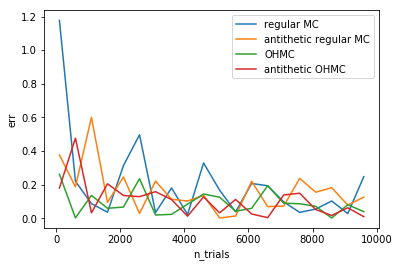

In [17]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

mc_trails = performance_df2[performance_df2["method"]=="MC"]["n_trials"]
mc_err = performance_df2[performance_df2["method"]=="MC"]["err"]
ax.plot(mc_trails,mc_err,label="regular MC")

anti_mc_trails = performance_df2[performance_df2["method"]=="antithetic MC"]["n_trials"]
anti_mc_err = performance_df2[performance_df2["method"]=="antithetic MC"]["err"]
ax.plot(anti_mc_trails,anti_mc_err,label="antithetic regular MC")

ohmc_trails = performance_df2[performance_df2["method"]=="OHMC"]["n_trials"]
ohmc_err = performance_df2[performance_df2["method"]=="OHMC"]["err"]
ax.plot(ohmc_trails,ohmc_err,label="OHMC")

anti_ohmc_trails = performance_df2[performance_df2["method"]=="antithetic OHMC"]["n_trials"]
anti_ohmc_err = performance_df2[performance_df2["method"]=="antithetic OHMC"]["err"]
ax.plot(anti_ohmc_trails,anti_ohmc_err,label="antithetic OHMC")

ax.legend()
plt.xlabel("n_trials")
plt.ylabel("err")

plt.show()

### 4.2 Runtime Efficiency Test

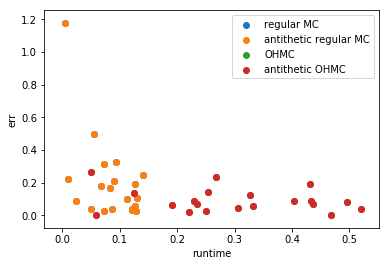

In [18]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

mc_runtime = performance_df2[performance_df2["method"]=="MC"]["runtime"]
mc_err = performance_df2[performance_df2["method"]=="MC"]["err"]
ax.scatter(mc_runtime,mc_err,label="regular MC")

anti_mc_runtime = performance_df2[performance_df2["method"]=="antithetic MC"]["runtime"]
anti_mc_err = performance_df2[performance_df2["method"]=="antithetic MC"]["err"]
ax.scatter(mc_runtime,mc_err,label="antithetic regular MC")

ohmc_runtime = performance_df2[performance_df2["method"]=="OHMC"]["runtime"]
ohmc_err = performance_df2[performance_df2["method"]=="OHMC"]["err"]
ax.scatter(ohmc_runtime,ohmc_err,label="OHMC")

anti_ohmc_runtime = performance_df2[performance_df2["method"]=="antithetic OHMC"]["runtime"]
anti_ohmc_err = performance_df2[performance_df2["method"]=="antithetic OHMC"]["err"]
ax.scatter(ohmc_runtime,ohmc_err,label="antithetic OHMC")

ax.legend()
plt.xlabel("runtime")
plt.ylabel("err")

plt.show()

### 4.3 Conclusion

From the test, one can see OHMC reduce the variance considerably, which make it more appreciable when number of trails is limited. For example, if we can only make trails less than 1000, OHMC is definite better than regular MC. However the runtime efficiency is similar based our observation. It seems slightly stable than regular MC, but still not enough to affirm that. As for the antithetic variates' version, there is no promotion in time efficiency and the variance reduction effect is valid only when number of trajectories is small enough and not gauranteed. Therefore, the antithetic variates method is not effective enough, the delta-based method is neither time efficient nor practical. At last, we highly recommand the optimal hedged Monte Carlo simulation as it is efficient, accurate and compatible to most of the stochastic process.